---
title: "Overfitting and underfitting"
output: 
  html_notebook: 
    theme: cerulean
    highlight: textmate
---



***

This notebook contains the code samples found in Chapter 4, Section 1 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

In all the examples we saw in the previous chapter -- movie review sentiment prediction, topic classification, and house price regression -- we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start degrading, i.e. our model would quickly start to _overfit_ to the training data. Overfitting happens in every single machine learning problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our movie classification model from the previous chapter.

Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

Let's prepare the data using the code from Chapter 3, Section 5:

In [0]:
install.packages('keras')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’




In [0]:
library(keras)

imdb <- dataset_imdb(num_words = 10000)
c(c(train_data, train_labels), c(test_data, test_labels)) %<-% imdb

vectorize_sequences <- function(sequences, dimension = 10000) {
  # Create an all-zero matrix of shape (len(sequences), dimension)
  results <- matrix(0, nrow = length(sequences), ncol = dimension)
  for (i in 1:length(sequences))
    # Sets specific indices of results[i] to 1s
    results[i, sequences[[i]]] <- 1
  results
}

# Our vectorized training data
x_train <- vectorize_sequences(train_data)
# Our vectorized test data
x_test <- vectorize_sequences(test_data)

# Our vectorized labels
y_train <- as.numeric(train_labels)
y_test <- as.numeric(test_labels)

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [0]:
original_model <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

original_model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

Now let's try to replace it with this smaller network:

In [0]:
smaller_model <- keras_model_sequential() %>% 
  layer_dense(units = 4, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 4, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

smaller_model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("accuracy")
)

Let's train both the original and smaller network:

In [0]:
original_hist <- original_model %>% fit(
  x_train, y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_test, y_test)
)

In [0]:
smaller_model_hist <- smaller_model %>% fit(
  x_train, y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_test, y_test)
)

To compare the losses we'll write an R function that takes a named list of loss series and plots it:

Note: "gather" is a fucntion supplied by "tidyr" package.An example is:
```
library(tidyr)
set.seed(2020)
(d <- data.frame(
  t = seq.Date( as.Date('2020-01-01'), by = "day", length.out = 2),
  X = rnorm(2),  Y = rnorm(2), Z = rnorm(2)
))
gather( d, key = name, value = dev, X, Y)
```
will give you:
```
           t         X         Y          Z
1 2020-01-01 0.3769721 -1.098023 -2.7965343
2 2020-01-02 0.3015484 -1.130406  0.7205735
```
```
           t          Z name        dev
1 2020-01-01 -2.7965343    X  0.3769721
2 2020-01-02  0.7205735    X  0.3015484
3 2020-01-01 -2.7965343    Y -1.0980232
4 2020-01-02  0.7205735    Y -1.1304059
```

In [0]:
library(ggplot2)
library(tidyr)
plot_training_losses <- function(losses) {
  loss_names <- names(losses)
  losses <- as.data.frame(losses)
  losses$epoch <- seq_len(nrow(losses))
  losses %>% 
    gather(model, loss, loss_names[[1]], loss_names[[2]]) %>% 
    ggplot(aes(x = epoch, y = loss, colour = model)) +
    geom_point()
}

Here's a comparison of the validation losses of the original network and the smaller network:

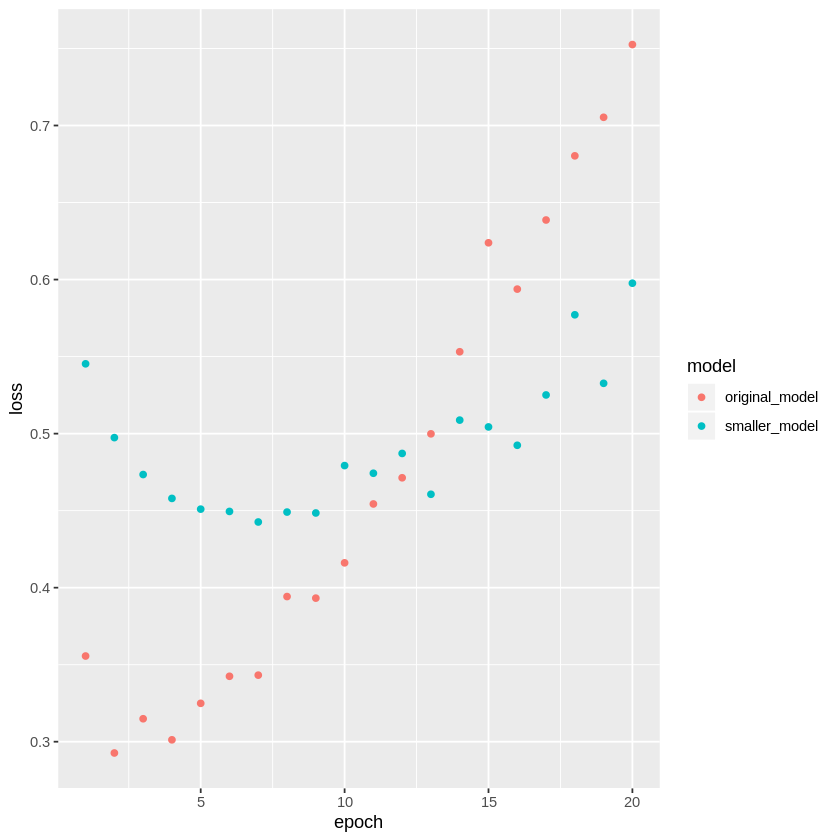

In [0]:
plot_training_losses(losses = list(
  original_model = original_hist$metrics$val_loss,
  smaller_model = smaller_model_hist$metrics$val_loss
))

As you can see, the smaller network starts overfitting later than the reference one and its performance degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [0]:
bigger_model <- keras_model_sequential() %>% 
  layer_dense(units = 512, activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

bigger_model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c('acc')
)

In [0]:
bigger_model_hist <- bigger_model %>% fit(
  x_train, y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_test, y_test)
)

Here's how the bigger network fares compared to the reference one:

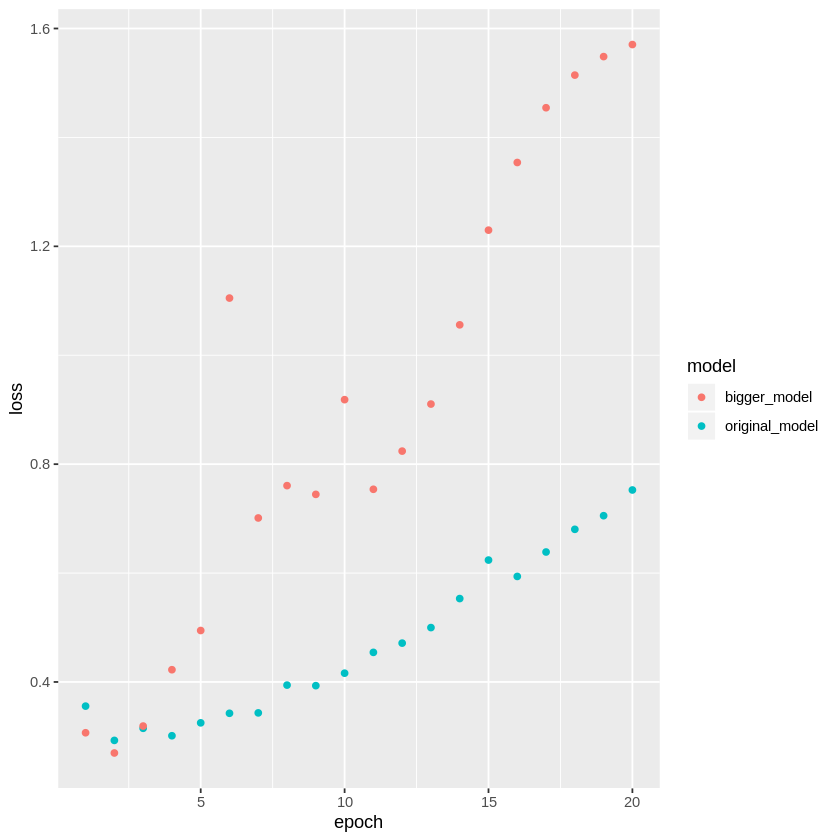

In [0]:
plot_training_losses(losses = list(
  original_model = original_hist$metrics$val_loss,
  bigger_model = bigger_model_hist$metrics$val_loss
))

The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also more noisy.

Meanwhile, here are the training losses for our two networks:

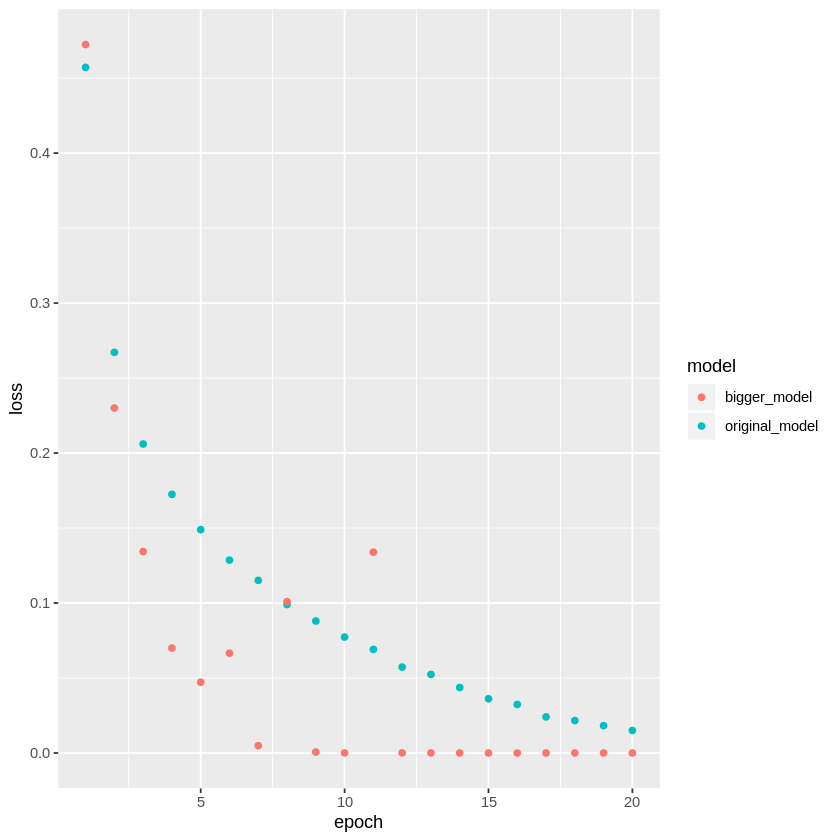

In [0]:
plot_training_losses(losses = list(
  original_model = original_hist$metrics$loss,
  bigger_model = bigger_model_hist$metrics$loss
))

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the "L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight regularization to our movie review classification network:

In [0]:
l2_model <- keras_model_sequential() %>% 
  layer_dense(units = 16, kernel_regularizer = regularizer_l2(0.001),
              activation = "relu", input_shape = c(10000)) %>% 
  layer_dense(units = 16, kernel_regularizer = regularizer_l2(0.001),
              activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

l2_model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("acc")
)

`regularizer_l2(0.001)` means every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training than at test time. 

Here's the impact of our L2 regularization penalty:

In [0]:
l2_model_hist <- l2_model %>% fit(
  x_train, y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_test, y_test)
)

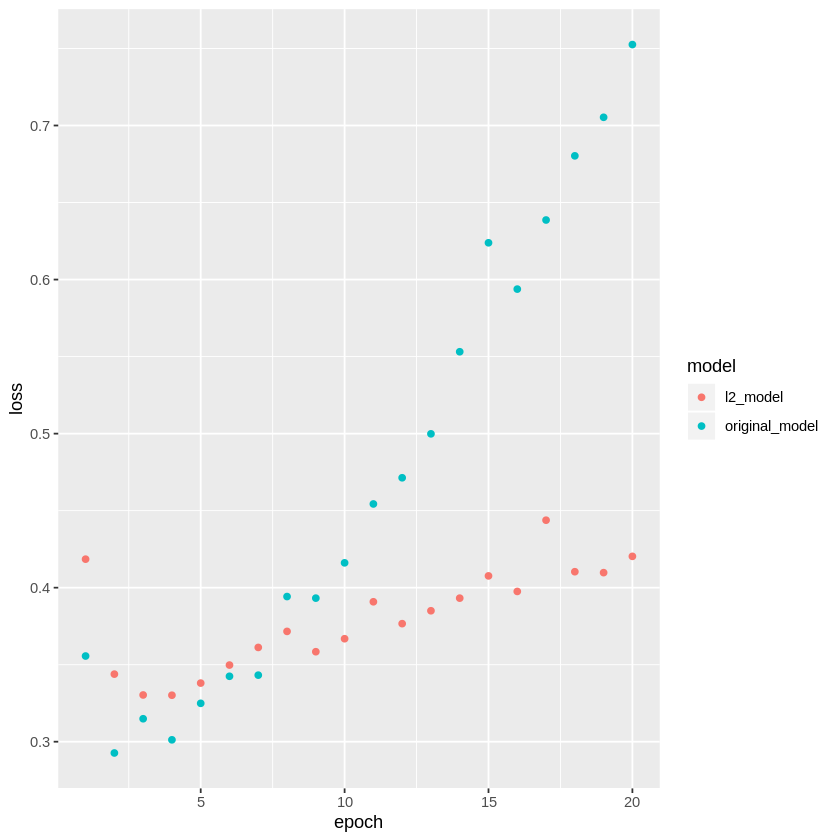

In [0]:
plot_training_losses(losses = list(
  original_model = original_hist$metrics$val_loss,
  l2_model = l2_model_hist$metrics$val_loss
))

As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model, even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [0]:
# L1 regularization
regularizer_l1(0.001)

# L1 and L2 regularization at the same time
regularizer_l1_l2(l1 = 0.001, l2 = 0.001)

<tensorflow.python.keras.regularizers.L1L2>

<tensorflow.python.keras.regularizers.L1L2>

## Adding dropout

```
# At training time: we drop out 50% of the units in the output
layer_output <- layer_output * sample(0:1, length(layer_output),
                                      replace = TRUE)  
```

At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the units):

```
# At test time:
layer_output <- layer_output * 0.5 
```

Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is often the way it is implemented in practice:

```
# At training time:
layer_output <- layer_output * sample(0:1, length(layer_output),
                                      replace = TRUE) 

# Note that we are scaling *up* rather scaling *down* in this case
layer_output <- layer_output / 0.5
```

```
# At training time:
layer_output <- layer_output * sample(0:1, length(layer_output),
                                      replace = TRUE) 

# Note that we are scaling *up* rather scaling *down* in this case
layer_output <- layer_output / 0.5
```

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras, you can introduce dropout in a network via `layer_dropout()`, which is applied to the output of layer right before it:

```
layer_dropout(rate = 0.5)
```

Let's add two dropout layers in our IMDB network to see how well they do at reducing overfitting:

In [0]:
dpt_model <- keras_model_sequential() %>% 
  layer_dense(units = 16, activation = "relu", input_shape = c(10000)) %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 16, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 1, activation = "sigmoid")

dpt_model %>% compile(
  optimizer = "rmsprop",
  loss = "binary_crossentropy",
  metrics = c("acc")
)

In [0]:
dpt_model_hist <- dpt_model %>% fit(
  x_train, y_train,
  epochs = 20,
  batch_size = 512,
  validation_data = list(x_test, y_test)
)

Let's plot the results:

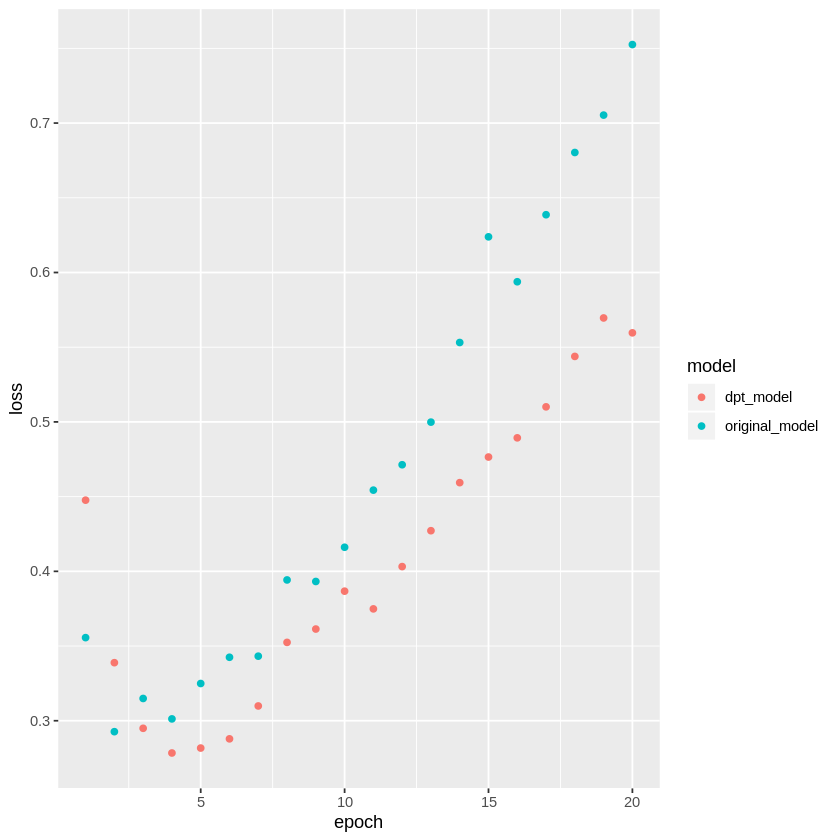

In [0]:
plot_training_losses(losses = list(
  original_model = original_hist$metrics$val_loss,
  dpt_model = dpt_model_hist$metrics$val_loss
))

Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.